# This is an exercise in using Vega-Lite and Altair API to visualize some of the obtained results. 

### Preface 
In order to take advantage of the Altair API, the corresponding library has to be added to the environment "cognoma-machine-learning". To that end, the file environment.yml in the root directory of the "machine-learning" repo has to be modified:
```
- pip:
  ...
  - altair==1.2.0
```
After that, the environment has to be recreated, by running two commands in the shell terminal, __from the root directory of the "machine-learning" repo__:
```
conda remove --name cognoma-machine-learning --all
conda env create -f environment.yml
```

### Part 1: Recreate the previous result with Seaborn
Now we are ready to proceed. As a starting point, we make an attempt to recreate the heatmap that shows the connection between different types of cancer and various gene mutations. This has been originally done in "3.TCGA-MLexample_Pathway.ipynb" so the first part of this notebook simply replicates those steps in order to create the original heatmap using Seaborn.

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad
from neo4j.v1 import GraphDatabase
%matplotlib inline
plt.style.use('seaborn-notebook')

#### Specify model configuration - Generate genelist

In [2]:
names = ('label', 'rel_type', 'node_id')
query_params = [
    ('Pathway', 'PARTICIPATES_GpPW', 'PC7_7459'),             # "Signaling by Hippo" - Reactome
    ('BiologicalProcess', 'PARTICIPATES_GpBP', 'GO:0035329'), # "hippo signaling" - Gene Ontology
    ('BiologicalProcess', 'PARTICIPATES_GpBP', 'GO:0035330')  # "regulation of hippo signaling" - Gene Ontology
]

param_list = [dict(zip(names, qp)) for qp in query_params]

In [3]:
query = '''
MATCH (node)-[rel]-(gene)
WHERE node.identifier = {node_id}
  AND {label} in labels(node)
  AND {rel_type} = type(rel)
RETURN
  gene.identifier as entrez_gene_id,
  gene.name as gene_symbol
ORDER BY gene_symbol
'''

In [4]:
driver = GraphDatabase.driver("bolt://neo4j.het.io")
full_results_df = pd.DataFrame()
with driver.session() as session:
    for parameters in param_list:
        result = session.run(query, parameters)
        result_df = pd.DataFrame((x.values() for x in result), columns=result.keys())
        full_results_df = full_results_df.append(result_df, ignore_index=True)

classifier_genes_df = full_results_df.drop_duplicates().sort_values('gene_symbol').reset_index(drop=True)
classifier_genes_df['entrez_gene_id'] = classifier_genes_df['entrez_gene_id'].astype('str')

In [5]:
# Here are the genes that participate in the Hippo signaling pathway
classifier_genes_df

,entrez_gene_id,gene_symbol
0,84962,AJUBA
1,154796,AMOT
2,154810,AMOTL1
3,51421,AMOTL2
4,836,CASP3
5,8642,DCHS1
6,1856,DVL2
7,79633,FAT4
8,9113,LATS1
9,26524,LATS2


#### Load Data
If this doesn't work, due to missing files, run the note book _cognoma/machine-learning/1.download.ipynb_ which will create them

In [6]:
%%time
path = os.path.join('../../download', 'expression-matrix.tsv.bz2')
X = pd.read_table(path, index_col=0)

CPU times: user 4min 18s, sys: 17.4 s, total: 4min 35s
Wall time: 4min 52s


In [7]:
%%time
path = os.path.join('../../download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 2min 47s, sys: 14.3 s, total: 3min 2s
Wall time: 3min 14s


In [8]:
%%time
path = os.path.join('../../download', 'samples.tsv')
clinical = pd.read_table(path, index_col=0)

CPU times: user 34.5 ms, sys: 12.4 ms, total: 46.9 ms
Wall time: 85.4 ms


In [9]:
# Subset the Y matrix to only the genes to be classified
y_full = Y[classifier_genes_df['entrez_gene_id']]

In [10]:
y_full.columns = classifier_genes_df['gene_symbol']
y_full = y_full.assign(disease = clinical['disease'])

# This matrix now stores the final y matrix for the classifier (y['indicator'])
y = y_full.assign(indicator = y_full.max(axis=1))

In [74]:
unique_pos = y.groupby('disease').apply(lambda x: x['indicator'].sum())
# change name of 'TOTAL' column to make it clear that it is not
# a gene_symbol name, and force it to sort to end. 
# Use Unicode invisble space as first character
# The column should really be handled separately from gene_symbol columns
heatmap_df0 = y_full.groupby('disease').sum().assign(**{'\u200BTotal' : unique_pos})
heatmap_df = heatmap_df0.divide(y_full.disease.value_counts(sort=False).sort_index(), axis=0)

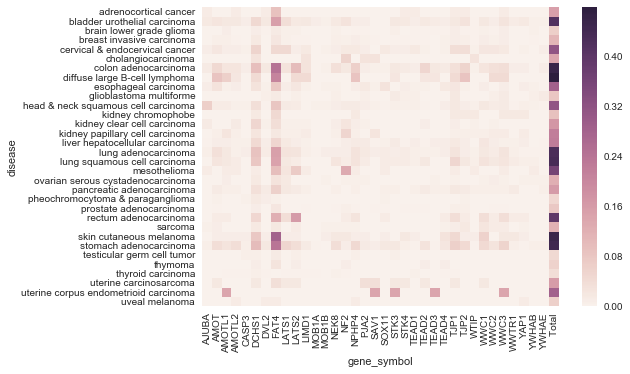

In [75]:
# What is the percentage of different mutations across different cancer types?
sns.heatmap(heatmap_df);

### Part 2: Building a Heatmap using Vega-Lite/Altair API

In order to take advantage of the Altair API, we have to covert the data into the so called long format (often referred to as the tidy format).

In [76]:
# Stack it: 
heatmap_df_stacked = heatmap_df.stack()
heatmap_df_stacked.head()

disease                gene_symbol
adrenocortical cancer  AJUBA          0.012821
                       AMOT           0.000000
                       AMOTL1         0.000000
                       AMOTL2         0.012821
                       CASP3          0.000000
dtype: float64

In [77]:
# The problem is that stack() produces an object 
# that is NOT Pandas Data Frame:
type(heatmap_df_stacked)

pandas.core.series.Series

In [78]:
# So let's convert it into the Pandas dataframe
heatmap_df_tidy = pd.DataFrame(heatmap_df_stacked)
heatmap_df_tidy.head(4)

0
disease               gene_symbol          
adrenocortical cancer AJUBA        0.012821
                      AMOT         0.000000
                      AMOTL1       0.000000
                      AMOTL2       0.012821

In [79]:
# Fix the index: Get rid of Multilevel
heatmap_df_tidy = heatmap_df_tidy.reset_index(level=['disease', 'gene_symbol'])
heatmap_df_tidy.head()

,disease,gene_symbol,0
0,adrenocortical cancer,AJUBA,0.012821
1,adrenocortical cancer,AMOT,0.000000
2,adrenocortical cancer,AMOTL1,0.000000
3,adrenocortical cancer,AMOTL2,0.012821
4,adrenocortical cancer,CASP3,0.000000


In [80]:
# Give the third column a meaningful name: 'frequency'
heatmap_df_tidy.columns = ['disease', 'gene_symbol', 'frequency']
heatmap_df_tidy.head()

,disease,gene_symbol,frequency
0,adrenocortical cancer,AJUBA,0.012821
1,adrenocortical cancer,AMOT,0.000000
2,adrenocortical cancer,AMOTL1,0.000000
3,adrenocortical cancer,AMOTL2,0.012821
4,adrenocortical cancer,CASP3,0.000000


###  Now we are ready to build the new heatmap

In [81]:
from altair import Row, Column, Chart, Text, Data, Color, Scale, Legend, Axis

def color_heatmap(data, row, column, column_to_color, 
                  colormap_domain, colormap_range, cellsize=(10, 10)):
    """Create an Altair/vega-lite Heat-Map with colormap parameter

    Parameters
    ----------
    data : dataframe to display, or url of csv file
    row, column, color, column_to_color : str
        Altair trait shorthands
    colormap_domain : list of strings - html color names, or hex value strings
    colormap_range : list of normalized values binned to colormap_domain
    cellsize : tuple
        specify (width, height) of cells in pixels
    """

    return Chart(data).mark_text(
        applyColorToBackground=True,
        ).encode(
            color=Color(column_to_color,
                scale=Scale(
                    domain=colormap_domain,
                    range=colormap_range
                ),
            ),
            column=Column(column,
                axis=Axis(
                    labelAngle=270.0,
                    orient='bottom',
                    title=column,
                    ),
                ),
            row=row,
            text=Text(
                value=' ',
            ),
        ).configure_scale(
               textBandWidth=cellsize[0],
               bandSize=cellsize[1]
        )

In [82]:
# get the viridis colormap from matplotlib
# convert from rgb triples to html/json hex string in '#rrggbb' 
# format expected in altair/vega-lite colormap

import matplotlib
import matplotlib.pyplot as plt
if matplotlib.__version__ >= str(2.0):
    plt_viridis_colors = plt.cm.viridis.colors
    vega_viridis_colormap = \
        [matplotlib.colors.to_hex(plt_viridis_colors[i]) 
            for i in range(len(plt_viridis_colors))]
else:
    vega_viridis_colormap = ['#440154', '#440256', '#450457', '#450559', '#46075a', '#46085c', '#460a5d', '#460b5e', '#470d60', '#470e61', '#471063', '#471164', '#471365', '#481467', '#481668', '#481769', '#48186a', '#481a6c', '#481b6d', '#481c6e', '#481d6f', '#481f70', '#482071', '#482173', '#482374', '#482475', '#482576', '#482677', '#482878', '#482979', '#472a7a', '#472c7a', '#472d7b', '#472e7c', '#472f7d', '#46307e', '#46327e', '#46337f', '#463480', '#453581', '#453781', '#453882', '#443983', '#443a83', '#443b84', '#433d84', '#433e85', '#423f85', '#424086', '#424186', '#414287', '#414487', '#404588', '#404688', '#3f4788', '#3f4889', '#3e4989', '#3e4a89', '#3e4c8a', '#3d4d8a', '#3d4e8a', '#3c4f8a', '#3c508b', '#3b518b', '#3b528b', '#3a538b', '#3a548c', '#39558c', '#39568c', '#38588c', '#38598c', '#375a8c', '#375b8d', '#365c8d', '#365d8d', '#355e8d', '#355f8d', '#34608d', '#34618d', '#33628d', '#33638d', '#32648e', '#32658e', '#31668e', '#31678e', '#31688e', '#30698e', '#306a8e', '#2f6b8e', '#2f6c8e', '#2e6d8e', '#2e6e8e', '#2e6f8e', '#2d708e', '#2d718e', '#2c718e', '#2c728e', '#2c738e', '#2b748e', '#2b758e', '#2a768e', '#2a778e', '#2a788e', '#29798e', '#297a8e', '#297b8e', '#287c8e', '#287d8e', '#277e8e', '#277f8e', '#27808e', '#26818e', '#26828e', '#26828e', '#25838e', '#25848e', '#25858e', '#24868e', '#24878e', '#23888e', '#23898e', '#238a8d', '#228b8d', '#228c8d', '#228d8d', '#218e8d', '#218f8d', '#21908d', '#21918c', '#20928c', '#20928c', '#20938c', '#1f948c', '#1f958b', '#1f968b', '#1f978b', '#1f988b', '#1f998a', '#1f9a8a', '#1e9b8a', '#1e9c89', '#1e9d89', '#1f9e89', '#1f9f88', '#1fa088', '#1fa188', '#1fa187', '#1fa287', '#20a386', '#20a486', '#21a585', '#21a685', '#22a785', '#22a884', '#23a983', '#24aa83', '#25ab82', '#25ac82', '#26ad81', '#27ad81', '#28ae80', '#29af7f', '#2ab07f', '#2cb17e', '#2db27d', '#2eb37c', '#2fb47c', '#31b57b', '#32b67a', '#34b679', '#35b779', '#37b878', '#38b977', '#3aba76', '#3bbb75', '#3dbc74', '#3fbc73', '#40bd72', '#42be71', '#44bf70', '#46c06f', '#48c16e', '#4ac16d', '#4cc26c', '#4ec36b', '#50c46a', '#52c569', '#54c568', '#56c667', '#58c765', '#5ac864', '#5cc863', '#5ec962', '#60ca60', '#63cb5f', '#65cb5e', '#67cc5c', '#69cd5b', '#6ccd5a', '#6ece58', '#70cf57', '#73d056', '#75d054', '#77d153', '#7ad151', '#7cd250', '#7fd34e', '#81d34d', '#84d44b', '#86d549', '#89d548', '#8bd646', '#8ed645', '#90d743', '#93d741', '#95d840', '#98d83e', '#9bd93c', '#9dd93b', '#a0da39', '#a2da37', '#a5db36', '#a8db34', '#aadc32', '#addc30', '#b0dd2f', '#b2dd2d', '#b5de2b', '#b8de29', '#bade28', '#bddf26', '#c0df25', '#c2df23', '#c5e021', '#c8e020', '#cae11f', '#cde11d', '#d0e11c', '#d2e21b', '#d5e21a', '#d8e219', '#dae319', '#dde318', '#dfe318', '#e2e418', '#e5e419', '#e7e419', '#eae51a', '#ece51b', '#efe51c', '#f1e51d', '#f4e61e', '#f6e620', '#f8e621', '#fbe723', '#fde725']


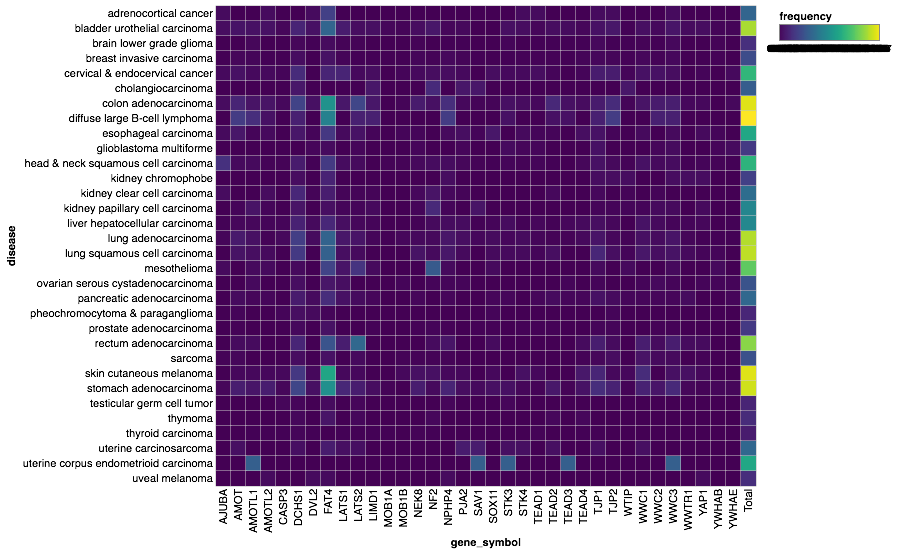

In [83]:
# save heatmap data frame as csv file
# this will keep down size of vega-lite json chart

heatmap_data_url = 'heatmap_data_Altair_compatible.csv'
heatmap_df_tidy.to_csv(heatmap_data_url)

# scale colormap domain into 0 to 1.0 by number of colors in colormap range
# this could be generalied to a non-linear scale

vals_to_color = 'frequency'
cm_len = len(vega_viridis_colormap)
minval = min(heatmap_df_tidy[vals_to_color])
maxval = max(heatmap_df_tidy[vals_to_color])


# normalize data frame frequency values into bins
# linear scale min..max
colormap_domain_vals = [minval + maxval *(i/(cm_len-1)) for i in range(cm_len)]
        
heatmap_chart = color_heatmap(Data(url=heatmap_data_url), 
                    row='disease', column='gene_symbol', 
                    column_to_color=vals_to_color, 
                    colormap_domain=colormap_domain_vals, 
                    colormap_range=vega_viridis_colormap,
                    cellsize=(15, 15))

# save chart to json file
hm_url = './heatmap.json'
hm_file = open(hm_url,'w')
print(heatmap_chart.to_json(indent=2), file=hm_file)
hm_file.close()

# display it
heatmap_chart

### still need to rotate the heatmap legend, and fix blob of legend labels